In [2]:
# Data import
import pandas as pd
import numpy as np

used_car = pd.read_csv("../data/used_cars.csv")
used_car.head(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [3]:
# Dataset Dimensions
used_car.shape

(4009, 12)

First, additional information can be extracted from the dataset. The following steps involve feature engineering, which will be applied before conducting EDA.

In [4]:
# Transform milage and price into numerical features
used_car['milage'] = used_car['milage'].str.replace(' mi.', '').str.replace(',', '').astype(int)
used_car['price'] = used_car['price'].str.replace('$', '').str.replace(',', '').astype('int64')

In [5]:
# Unify nan in fuel_type 
print(used_car["fuel_type"].unique())
used_car['fuel_type'] = used_car['fuel_type'].replace(['–', 'not supported'], np.nan)
print(used_car["fuel_type"].unique())

['E85 Flex Fuel' 'Gasoline' 'Hybrid' nan 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']
['E85 Flex Fuel' 'Gasoline' 'Hybrid' nan 'Diesel' 'Plug-In Hybrid']


In [6]:
print(len(used_car["engine"].unique()))
print(len(used_car["transmission"].unique()))

1146
62


Both the "engine" and "transmission" columns are categorical variables with too many distinct categories, which limits their predictive usefulness in their current form. However, since both columns contain detailed descriptions as strings, valuable information can still be extracted. From the "engine" column, I can derive attributes such as horsepower, engine displacement, the number of cylinders, and whether the engine is turbocharged. Similarly, from the "transmission" column, I can extract whether it is automatic or manual and the number of gears.

In [7]:
# Extract horsepower from engine
def extract_horsepower(engine):
    match = pd.Series(engine).str.extract(r'(\d+\.?\d*)HP')
    return match[0] if not match.empty else np.nan

used_car['horsepower'] = used_car['engine'].apply(extract_horsepower).astype(float)

In [8]:
# Extract engine displacement from engine
def extract_displacement(engine):
    match = pd.Series(engine).str.extract(r'(\d+\.?\d*)\s*(L|Liter)')
    return match[0] if not match.empty else np.nan

used_car['displacement'] = used_car['engine'].apply(extract_displacement).astype(float)

In [9]:
# Extract cylinders from engine
def extract_cylinders(engine):
    match = pd.Series(engine).str.extract(r'(?:V|I)(\d+)|(\d+)\s*Cylinder')
    return match[0].combine_first(match[1]) if not match.empty else np.nan

used_car['cylinders'] = used_car['engine'].apply(extract_cylinders).astype(float)

In [10]:
# Determine whether an engine has turbo
def extract_turbo(engine):
    if "turbo" in engine.lower():
        return True
    else:
        return False
    
used_car['turbo'] = used_car['engine'].apply(extract_turbo)

In [11]:
# Classify Transmission into Automatic, Manual and Other
def classify_transmission(transmission):
    if "manual" in transmission.lower() or "m/t" in transmission.lower():
        return "Manual"
    elif "automatic" in transmission.lower() or "a/t" in transmission.lower():
        return "Automatic"
    else:
        return np.nan

used_car['transmission_type'] = used_car['transmission'].apply(classify_transmission)

In [12]:
# Create a new column num_gears by extracting the number of gears from transmission
def extract_gears(transmission):
    match = pd.Series(transmission).str.extract(r'(\d+)')
    return match[0] if not match.empty else np.nan

used_car['gears'] = used_car['transmission'].apply(extract_gears).astype(float)

In [13]:
# Check the transmission_type, and gears of each unique transformation
# pd.set_option('display.max_rows', None)
unique_transmissions = used_car[['transmission', 'transmission_type', 'gears']].drop_duplicates()
display(unique_transmissions)

,transmission,transmission_type,gears
0,6-Speed A/T,Automatic,6.0
1,8-Speed Automatic,Automatic,8.0
2,Automatic,Automatic,NaN
3,7-Speed A/T,Automatic,7.0
5,F,NaN,NaN
...,...,...,...
2393,9-Speed Automatic with Auto-Shift,Automatic,9.0
2620,SCHEDULED FOR OR IN PRODUCTION,NaN,NaN
2772,2-Speed A/T,Automatic,2.0
3206,6 Speed Mt,NaN,6.0


In [14]:
# Drop engine and transmission columns
used_car.drop(['engine', 'transmission'], axis=1, inplace=True)

In [15]:
used_car.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'ext_col',
       'int_col', 'accident', 'clean_title', 'price', 'horsepower',
       'displacement', 'cylinders', 'turbo', 'transmission_type', 'gears'],
      dtype='object')

### Next, we start the EDA procedures for the transformed dataset.

In [16]:
# dataset dimensions
used_car.shape

(4009, 16)

In [17]:
# Column data types
for col in used_car.columns:
    print(f"Column: {col}, Data type: {used_car[col].dtype}")

Column: brand, Data type: object
Column: model, Data type: object
Column: model_year, Data type: int64
Column: milage, Data type: int64
Column: fuel_type, Data type: object
Column: ext_col, Data type: object
Column: int_col, Data type: object
Column: accident, Data type: object
Column: clean_title, Data type: object
Column: price, Data type: int64
Column: horsepower, Data type: float64
Column: displacement, Data type: float64
Column: cylinders, Data type: float64
Column: turbo, Data type: bool
Column: transmission_type, Data type: object
Column: gears, Data type: float64


In [18]:
# Describe the target variable "sales price"
sales_price = used_car['price']
sales_price.describe()

count    4.009000e+03
mean     4.455319e+04
std      7.871064e+04
min      2.000000e+03
25%      1.720000e+04
50%      3.100000e+04
75%      4.999000e+04
max      2.954083e+06
Name: price, dtype: float64

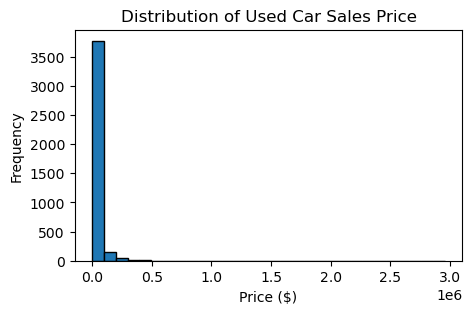

19.51355120421606


In [19]:
import matplotlib.pyplot as plt

# Histogram of sales_price
plt.figure(figsize=(5,3))
plt.hist(sales_price, bins=30, edgecolor='black')
plt.title("Distribution of Used Car Sales Price")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.savefig('../figures/car_price_bar.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


print(sales_price.skew())

This the skewness is significantly larger than 0, the target variable is right-skewed.

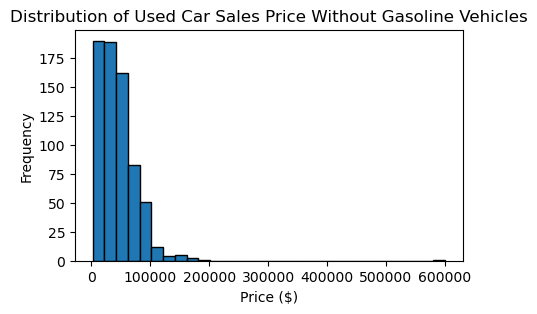

5.912025373385191


In [20]:
# Histogram of sales_price
used_car_no_gasoline = used_car[used_car['fuel_type'] != 'Gasoline']
plt.figure(figsize=(5,3))
plt.hist(used_car_no_gasoline['price'], bins=30, edgecolor='black')
plt.title("Distribution of Used Car Sales Price Without Gasoline Vehicles")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.savefig('../figures/car_price_bar_no_gas.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

print(used_car_no_gasoline['price'].skew())

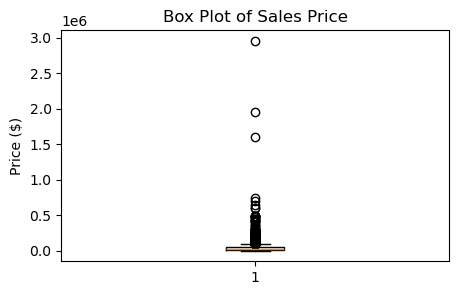

In [21]:
# Boxplot of sales_price
plt.figure(figsize=(5, 3))
plt.boxplot(sales_price)
plt.title('Box Plot of Sales Price')
plt.ylabel('Price ($)')
plt.savefig('../figures/car_price_box.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


In [22]:
# Identify outliers based on the IQR method
Q1 = sales_price.quantile(0.25)
Q3 = sales_price.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
outliers = used_car[sales_price > upper_bound]

# Display the outliers
print(outliers)


              brand                      model  model_year  milage fuel_type  \
11            Aston    Martin DBS Superleggera        2019   22770  Gasoline   
16    Mercedes-Benz                Metris Base        2021    1685  Gasoline   
44            Lucid          Air Grand Touring        2022    3552       NaN   
61             Audi                 R8 5.2 V10        2018    8940  Gasoline   
71          Bentley         Continental GT W12        2017   14684  Gasoline   
...             ...                        ...         ...     ...       ...   
3964        Porsche                911 Carrera        2022    2950  Gasoline   
3993        Porsche              911 Carrera S        2021    7008  Gasoline   
3994            BMW  M8 Gran Coupe Competition        2022   21057  Gasoline   
4002  Mercedes-Benz          AMG GLS 63 4MATIC        2023    2000    Hybrid   
4004        Bentley       Continental GT Speed        2023     714  Gasoline   

                 ext_col  int_col      

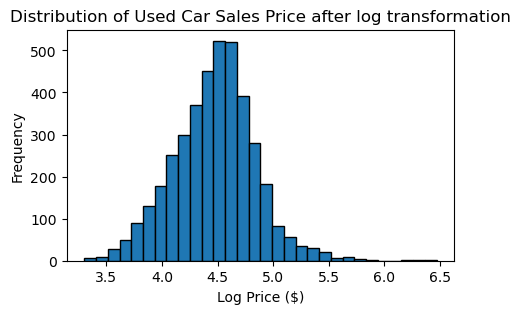

0.10559179534941895


In [23]:
# Log Transformation
used_car['sales_price_log'] = np.log10(used_car['price'])
plt.figure(figsize=(5,3))
plt.hist(used_car['sales_price_log'], bins=30, edgecolor='black')
plt.title("Distribution of Used Car Sales Price after log transformation")
plt.xlabel("Log Price ($)")
plt.ylabel("Frequency")
plt.savefig('../figures/log_car_price_bar.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


print(used_car['sales_price_log'].skew())

In [24]:
# Distribution of Log Transformed Sales Price
used_car['sales_price_log'].describe()

count    4009.000000
mean        4.474255
std         0.369193
min         3.301030
25%         4.235528
50%         4.491362
75%         4.698883
max         6.470423
Name: sales_price_log, dtype: float64

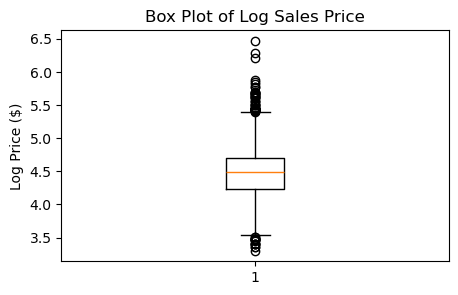

In [25]:
# Boxplot of log tranformed sales_price
plt.figure(figsize=(5, 3))
plt.boxplot(used_car['sales_price_log'])
plt.title('Box Plot of Log Sales Price')
plt.ylabel('Log Price ($)')
plt.savefig('../figures/log_car_price_box.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

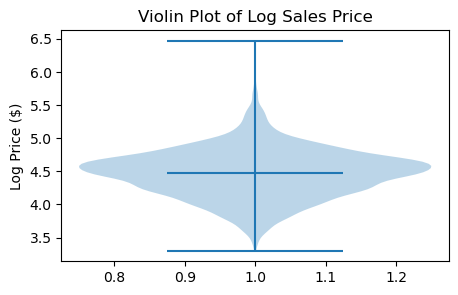

In [26]:
# Violinplot of log tranformed sales_price
plt.figure(figsize=(5, 3))
plt.violinplot(used_car['sales_price_log'], showmeans=True)
plt.title('Violin Plot of Log Sales Price')
plt.ylabel('Log Price ($)')
plt.savefig('../figures/log_car_price_violin.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Missing Value Detection
perc_missing_per_ftr = used_car.isnull().sum(axis=0) / used_car.shape[0]
print('Fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

print('Data types of the features with missing values:')
print(used_car[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

frac_missing = sum(used_car.isnull().sum(axis=1) != 0) / used_car.shape[0]
print('Fraction of points with missing values:', frac_missing)

Fraction of missing values in features:
fuel_type            0.054128
accident             0.028187
clean_title          0.148666
horsepower           0.201547
displacement         0.054128
cylinders            0.109753
transmission_type    0.121976
gears                0.457221
dtype: float64
Data types of the features with missing values:
fuel_type             object
accident              object
clean_title           object
horsepower           float64
displacement         float64
cylinders            float64
transmission_type     object
gears                float64
dtype: object
Fraction of points with missing values: 0.6083811424295336


### Some Categorical vs Continuous Plots

/home/lshiyu/anaconda3/envs/data1030_env/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


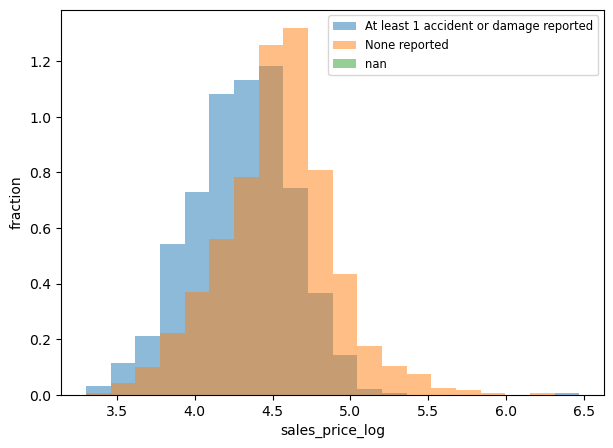

In [28]:
# Accident vs log sales price
categories = used_car['accident'].unique()
bin_range = (used_car['sales_price_log'].min(),used_car['sales_price_log'].max())

plt.figure(figsize=(7,5))

for c in categories:
    plt.hist(used_car[used_car['accident']==c]['sales_price_log'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend(fontsize='small')
plt.ylabel('fraction')
plt.xlabel('sales_price_log')
plt.savefig('../figures/log_car_price_accident.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

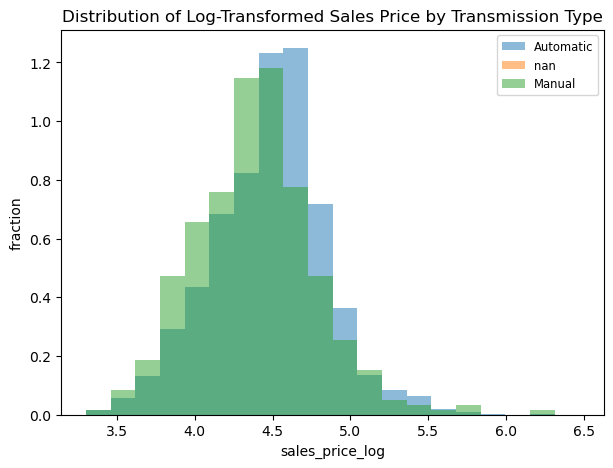

In [29]:
# Transmission type vs log sales price
categories = used_car['transmission_type'].unique()
bin_range = (used_car['sales_price_log'].min(),used_car['sales_price_log'].max())

plt.figure(figsize=(7,5))

for c in categories:
    plt.hist(used_car[used_car['transmission_type']==c]['sales_price_log'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend(fontsize='small')
plt.title("Distribution of Log-Transformed Sales Price by Transmission Type")
plt.ylabel('fraction')
plt.xlabel('sales_price_log')
plt.savefig('../figures/log_car_price_transmission.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 700x500 with 0 Axes>

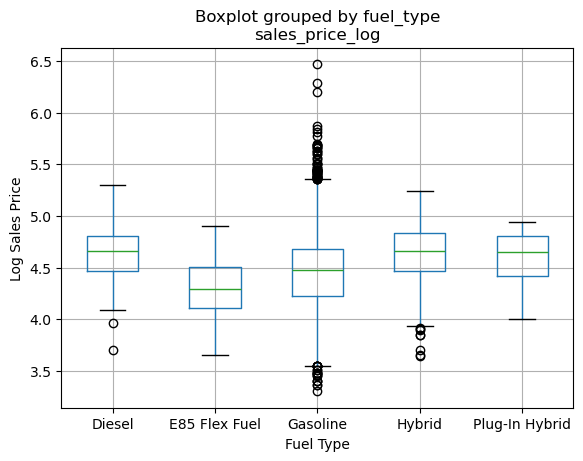

In [ ]:
# Side-by-side Box Plot of fuel_type vs log sales price
plt.figure(figsize=(7,5))

used_car[['sales_price_log','fuel_type']].boxplot(by='fuel_type')

plt.ylabel('Log Sales Price')
plt.xlabel('Fuel Type')
plt.savefig('../figures/log_car_price_fuel_type.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

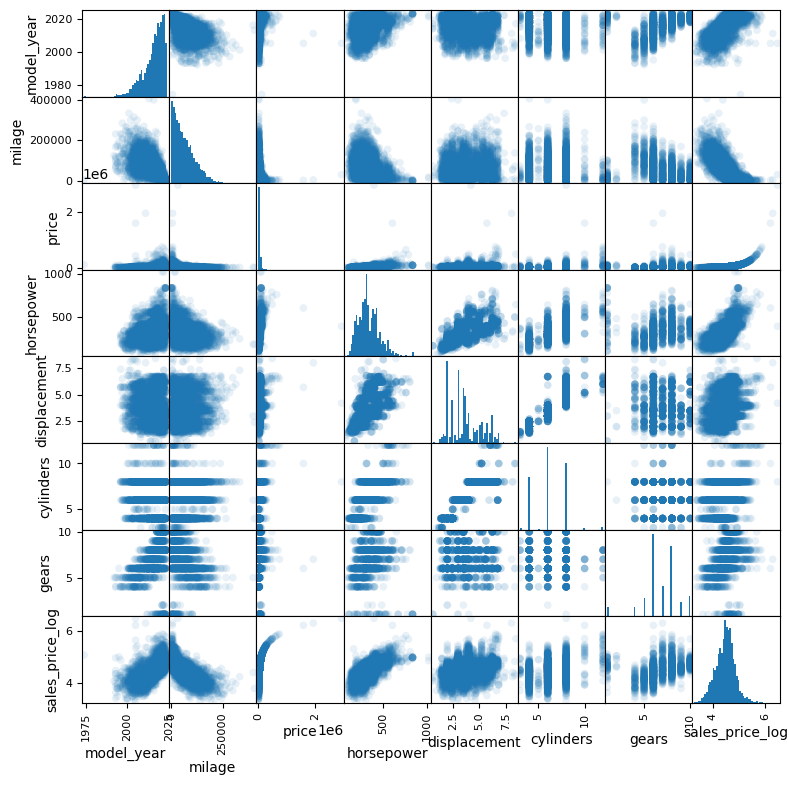

In [ ]:
# Scattered Matrix of Numerical Features
pd.plotting.scatter_matrix(used_car.select_dtypes("number"), figsize=(9, 9), marker='o',hist_kwds={'bins': 50}, 
                           s=30, alpha=.1)
plt.savefig('../figures/scattered_matrix.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

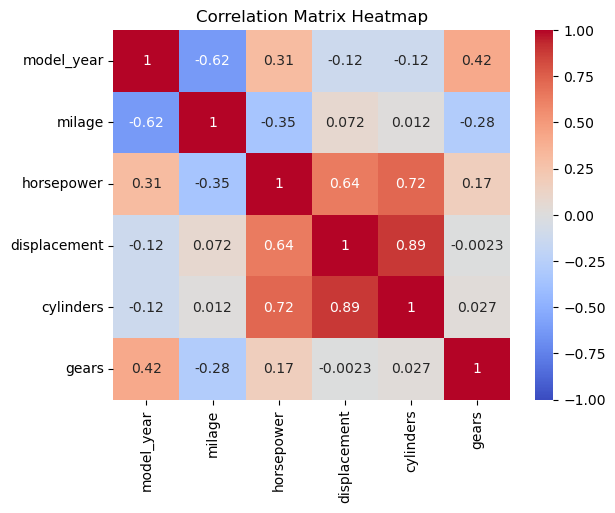

In [ ]:
# Correlation Matrix Heatmap of Numerical Features
import seaborn as sns

numeric_df = used_car.drop(['price', 'sales_price_log'], axis=1).select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Matrix Heatmap')
plt.savefig('../figures/heatmap.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
# Output the processed data
used_car.to_csv('../data/processed_used_car.csv', index=False)